In [2]:
%load_ext lab_black

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys

sys.path.insert(0, "../..")

In [5]:
import time
import copy

import pandas as pd
import numpy as np
import altair as alt

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageFile

from seefood.model import CalorieNet

ImageFile.LOAD_TRUNCATED_IMAGES = True

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
def get_metrics(name, y_test, y_pred):
    return pd.DataFrame(
        {
            "experiment_name": name,
            "r2_score": [r2_score(y_test, y_pred)],
            "explained_variance_score": [explained_variance_score(y_test, y_pred)],
            "max_error": [max_error(y_test, y_pred)],
            "mean_absolute_error": [mean_absolute_error(y_test, y_pred)],
            "mean_squared_error": [mean_squared_error(y_test, y_pred)],
            "median_absolute_error": [median_absolute_error(y_test, y_pred)],
        }
    )

## Load data

In [7]:
df_recipes = pd.read_csv("../../data/sparkrecipes_filtered.csv")
df_recipes

,recipe_id,title,total_calories,url,servings
0,19,Turkey Stuffed Cabbage,155.5,https://recipes.sparkpeople.com/recipe-detail....,10.0
1,25,Easy Lemon Chicken,318.0,https://recipes.sparkpeople.com/recipe-detail....,4.0
2,29,Bavarian Beef,256.1,https://recipes.sparkpeople.com/recipe-detail....,5.0
3,37,Garlic Mashed Potatoes,167.6,https://recipes.sparkpeople.com/recipe-detail....,4.0
4,40,Wonderful Stuffed Potatoes,164.4,https://recipes.sparkpeople.com/recipe-detail....,8.0
...,...,...,...,...,...
446709,3199895,M4G's Loaded Split Pea & Ham Soup,164.4,https://recipes.sparkpeople.com/recipe-detail....,16.0
446710,3199906,Vegetarian Skyline Chili,191.6,https://recipes.sparkpeople.com/recipe-detail....,4.0
446711,3199939,2 FEV 17 Lemon cheese cake fat bomb,122.9,https://recipes.sparkpeople.com/recipe-detail....,14.0
446712,3199943,Lentil soup,117.8,https://recipes.sparkpeople.com/recipe-detail....,6.0


In [8]:
df_images = pd.read_csv("../../data/sparkrecipes_images.csv")
df_images.shape

(1726537, 2)

In [9]:
df_nn = df_recipes.merge(df_images, how="inner").sample(100)
df_nn

,recipe_id,title,total_calories,url,servings,image_path
811957,265013,Far East Rice,270.1,https://recipes.sparkpeople.com/recipe-detail....,4.0,../../data/images/265013/000002
171108,63163,Oatmeal Pancakes,110.7,https://recipes.sparkpeople.com/recipe-detail....,6.0,../../data/images/63163/000005
1114165,364264,Jo's Special,88.5,https://recipes.sparkpeople.com/recipe-detail....,6.0,../../data/images/364264/000008
148933,56675,Verde Chicken Enchiladas,422.4,https://recipes.sparkpeople.com/recipe-detail....,4.0,../../data/images/56675/000005
613070,201830,Cock-a-Leekie,135.0,https://recipes.sparkpeople.com/recipe-detail....,7.0,../../data/images/201830/000015
...,...,...,...,...,...,...
1132086,370377,Green Beans with Tomatoes and Cheese,116.3,https://recipes.sparkpeople.com/recipe-detail....,4.0,../../data/images/370377/000011
714130,231659,Beef & Pepper Soup,115.9,https://recipes.sparkpeople.com/recipe-detail....,12.0,../../data/images/231659/000008
1281872,423643,Chicken salad,159.7,https://recipes.sparkpeople.com/recipe-detail....,6.0,../../data/images/423643/000007
1182415,387110,Potato soup,126.1,https://recipes.sparkpeople.com/recipe-detail....,14.0,../../data/images/387110/000002


In [10]:
df_nn.describe()

,recipe_id,total_calories,servings
count,100.000000,100.000000,100.000000
mean,214605.920000,208.756000,6.990000
std,126695.405274,96.977845,3.630663
min,1342.000000,47.600000,2.000000
25%,101495.750000,126.400000,4.000000
50%,217855.500000,198.000000,6.000000
75%,310234.500000,281.350000,8.250000
max,432207.000000,434.700000,16.000000


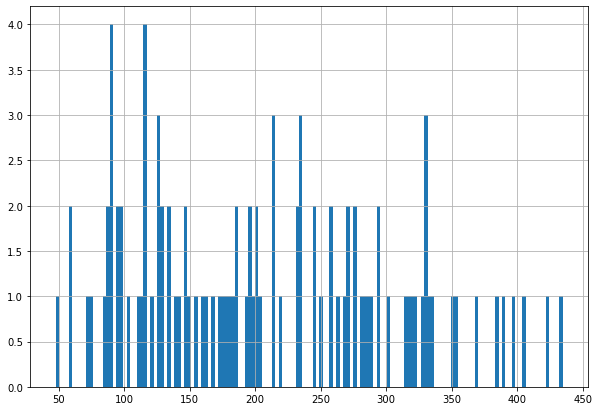

In [11]:
_ = df_nn.total_calories.hist(bins=150, figsize=(10, 7))

# Train Neural Network

In [12]:
IMAGE_SIZE = 224


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.images = X["image_path"].reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

        assert self.images.shape[0] == self.y.shape[0]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images.iloc[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        y = self.y.iloc[idx]
        return image, y


data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [13]:
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(
    df_nn[["image_path"]], np.log(df_nn.total_calories), test_size=0.33, random_state=42
)

In [14]:
dataloaders = {
    "train": torch.utils.data.DataLoader(
        ImageDataset(X_nn_train, y_nn_train, data_transforms["train"]),
        batch_size=16,
        shuffle=True,
        num_workers=3,
    ),
    "val": torch.utils.data.DataLoader(
        ImageDataset(X_nn_val, y_nn_val, data_transforms["val"]),
        batch_size=16,
        shuffle=True,
        num_workers=3,
    ),
}

dataset_sizes = {"train": X_nn_train.shape[0], "val": X_nn_val.shape[0]}

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
mobile_net = models.mobilenet_v2(pretrained=True)

In [16]:
device

device(type='cuda', index=0)

In [17]:
net = CalorieNet(mobile_net).to(device)

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    writer = SummaryWriter()
    since = time.time()
    training_loss = []
    validation_loss = []

    for epoch in tqdm(range(num_epochs)):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                training_loss.append(epoch_loss)
                writer.add_scalar("Loss/train", epoch_loss, epoch)
            else:
                validation_loss.append(epoch_loss)
                writer.add_scalar("Loss/val", epoch_loss, epoch)

    time_elapsed = time.time() - since

    print(f"Training complete in {time_elapsed/60}m {time_elapsed % 60}s")
    writer.close()
    return model, (training_loss, validation_loss)

In [19]:
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
model, metrics = train_model(net, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)



Training complete in 0.1395759423573812m 8.374556541442871s


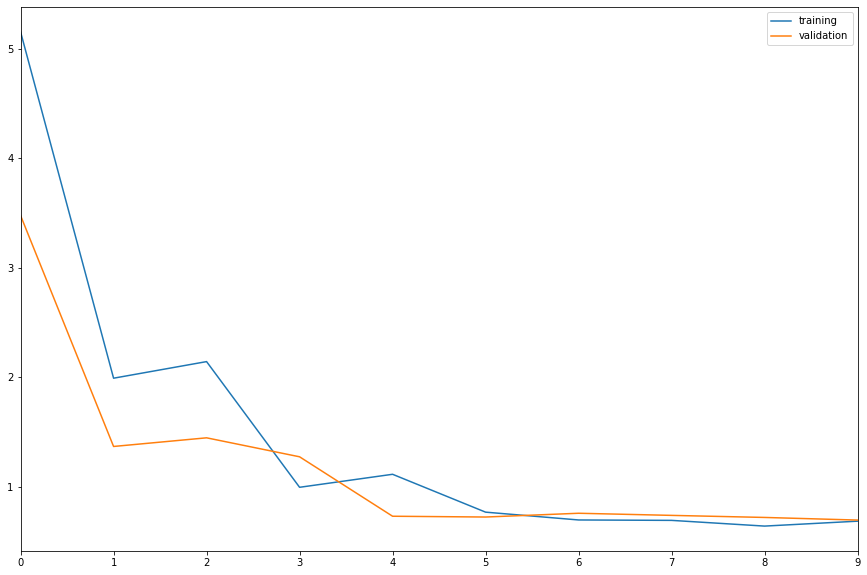

In [21]:
training_loss, validation_loss = metrics
pd.DataFrame({"training": training_loss, "validation": validation_loss}).plot.line(
    figsize=(15, 10)
)

In [22]:
predict_dataloader = torch.utils.data.DataLoader(
    ImageDataset(X_nn_val, y_nn_val, data_transforms["val"]),
    batch_size=100,
    shuffle=False,
    num_workers=3,
)

In [26]:
y_pred_nn = []
for inputs, _ in predict_dataloader:
    inputs = inputs.to(device)
    y_pred_nn.append(model(inputs).to(cpu))

> <ipython-input-26-3e241ce8b0f3>(5)<module>()
-> y_pred_nn.append(model(inputs).to(cpu))


(Pdb)  inputs


tensor([[[[ 0.5536,  0.5536,  0.5193,  ..., -0.6965, -0.7308, -0.7822],
          [ 0.5536,  0.5707,  0.5364,  ..., -0.6109, -0.6452, -0.6794],
          [ 0.5707,  0.5707,  0.5707,  ..., -0.4911, -0.5424, -0.5424],
          ...,
          [ 0.8104,  0.7762,  0.7248,  ...,  1.7523,  1.7694,  1.7865],
          [ 0.8447,  0.7933,  0.7762,  ...,  1.7865,  1.7865,  1.7865],
          [ 0.8789,  0.8276,  0.8104,  ...,  1.8037,  1.8037,  1.8037]],

         [[ 0.6254,  0.6254,  0.6254,  ..., -0.7927, -0.8102, -0.7927],
          [ 0.6254,  0.6429,  0.6429,  ..., -0.7052, -0.7052, -0.6877],
          [ 0.6429,  0.6429,  0.6429,  ..., -0.5826, -0.5651, -0.5651],
          ...,
          [ 0.3452,  0.3102,  0.2402,  ...,  1.9909,  2.0084,  2.0259],
          [ 0.3978,  0.3452,  0.2927,  ...,  2.0609,  2.0609,  2.0784],
          [ 0.4503,  0.3803,  0.3277,  ...,  2.0959,  2.0959,  2.0959]],

         [[ 0.8622,  0.8622,  0.8971,  ..., -0.7936, -0.7238, -0.7238],
          [ 0.8622,  0.8622,  

(Pdb)  model(inputs)


tensor([5.6206, 5.3466, 4.5342, 6.1432, 6.0808, 4.9570, 5.2888, 4.5717, 5.6032,
        3.9826, 5.3503, 5.3547, 6.2298, 6.0550, 6.0721, 4.6112, 4.8409, 4.6468,
        4.8383, 4.8124, 5.0186, 4.1358, 4.0153, 5.4381, 6.0630, 5.0152, 4.5386,
        4.9165, 4.7703, 4.6120, 5.2103, 5.1219, 6.1804], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


(Pdb)  q


BdbQuit: 

In [24]:
y_pred_nn_np = torch.flatten(torch.cat(y_pred_nn)).detach().numpy()

In [25]:
y_pred_nn

[tensor([5.6206, 5.3466, 4.5342, 6.1432, 6.0808, 4.9570, 5.2888, 4.5717, 5.6032,
         3.9826, 5.3503, 5.3547, 6.2298, 6.0550, 6.0721, 4.6112, 4.8409, 4.6468,
         4.8383, 4.8124, 5.0186, 4.1358, 4.0153, 5.4381, 6.0630, 5.0152, 4.5386,
         4.9165, 4.7703, 4.6120, 5.2103, 5.1219, 6.1804],
        grad_fn=<CopyBackwards>)]

In [25]:
df_nn_results = get_metrics("nn", y_nn_val, y_pred_nn_np)
df_nn_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,nn,-2.00387,-1.795407,1.471894,0.636693,0.557625,0.612364


## Create Baseline

In [26]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_is_fitted


class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass

    def fit(self, _, y):
        self.mean_ = y.mean()
        return self

    def predict(self, X):
        check_is_fitted(self, [])

        return np.array(X.shape[0] * [self.mean_])

In [27]:
baseline_model = BaselineModel()

In [28]:
baseline_model.fit(X_nn_train, y_nn_train)

BaselineModel()

In [29]:
y_pred_baseline = baseline_model.predict(X_nn_val)

In [30]:
df_baseline_results = get_metrics("baseline", y_nn_val, y_pred_baseline)
df_baseline_results

,experiment_name,r2_score,explained_variance_score,max_error,mean_absolute_error,mean_squared_error,median_absolute_error
0,baseline,-0.195634,0.0,1.009376,0.380424,0.221952,0.331821


## Compare NN to Baseline

In [31]:
df_results = pd.concat([df_baseline_results, df_nn_results]).reset_index(drop=True).T
df_results.columns = df_results.loc["experiment_name"].values
df_results = df_results.iloc[1:]

In [32]:
df_results

,baseline,nn
r2_score,-0.195634,-2.00387
explained_variance_score,0,-1.79541
max_error,1.00938,1.47189
mean_absolute_error,0.380424,0.636693
mean_squared_error,0.221952,0.557625
median_absolute_error,0.331821,0.612364


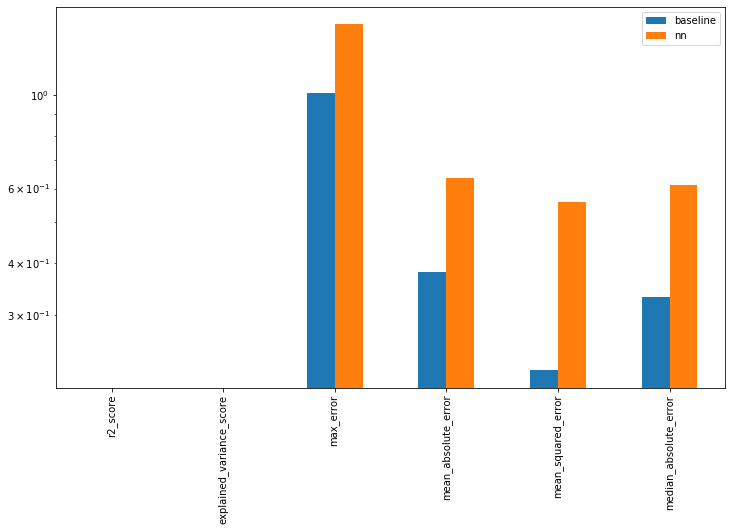

In [33]:
df_results.plot.bar(log=True, figsize=(12, 7))

## Inspect predictions

In [34]:
ylim = (0, 1200)

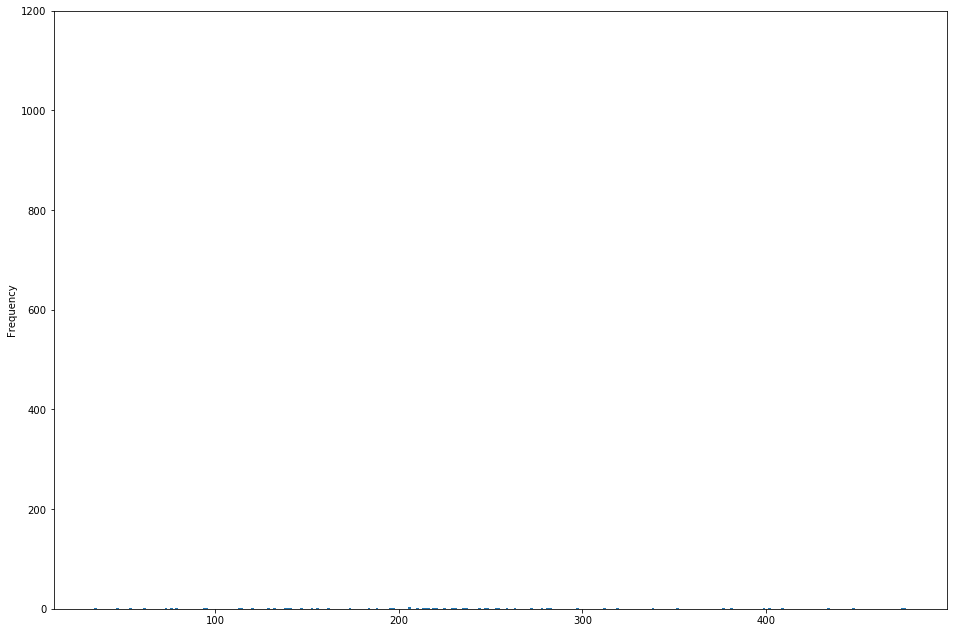

In [35]:
df_nn.loc[X_nn_train.index].total_calories.plot.hist(
    bins=300, figsize=(16, 11), ylim=ylim
)

In [36]:
df_predictions = df_nn.loc[X_nn_val.index].assign(
    predicted_calories=np.exp(y_pred_nn_np)
)

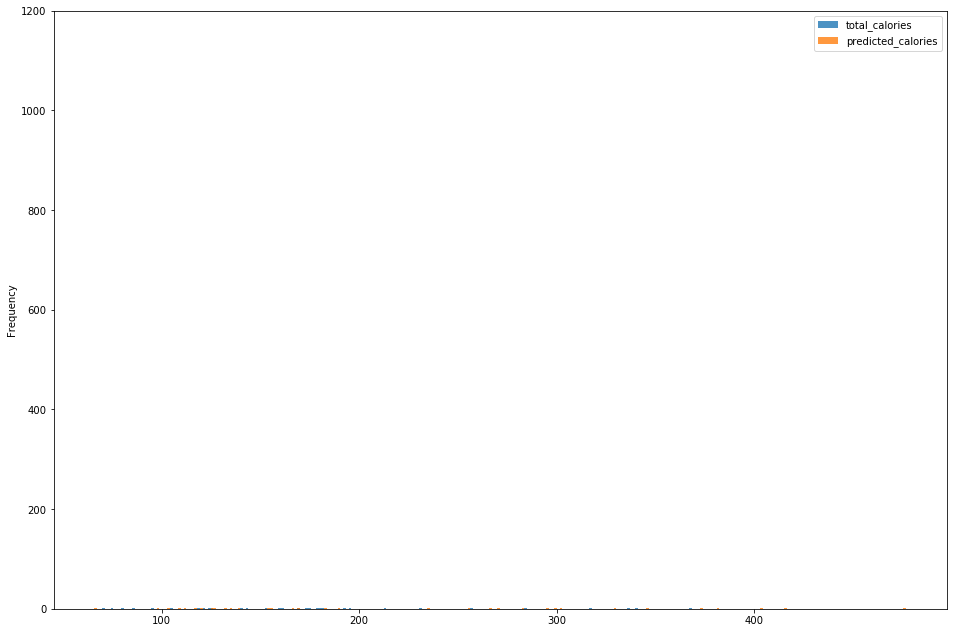

In [37]:
df_predictions[["total_calories", "predicted_calories"]].plot.hist(
    bins=300, figsize=(16, 11), alpha=0.8, ylim=ylim
)

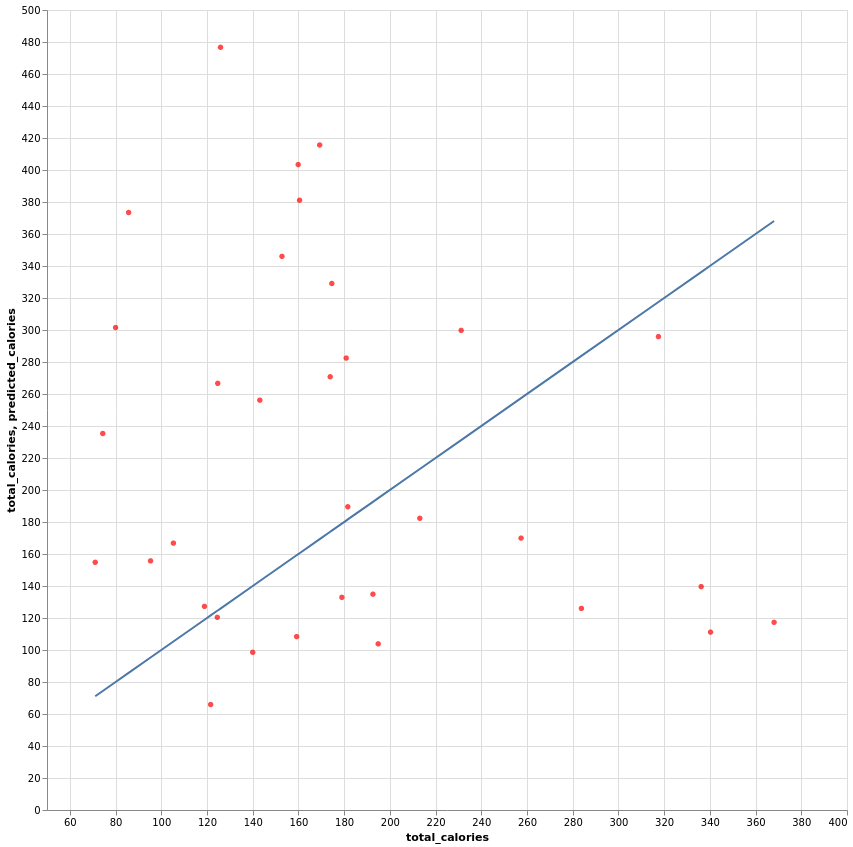

In [39]:
df_predictions_sample = df_predictions
line = (
    alt.Chart(df_predictions_sample)
    .mark_line()
    .encode(x="total_calories", y="total_calories")
)

scatter = (
    alt.Chart(df_predictions_sample)
    .mark_circle(color="red")
    .encode(
        x="total_calories",
        y="predicted_calories",
        tooltip=["title", "total_calories", "predicted_calories"],
    )
).interactive()

(line + scatter).properties(width=800, height=800)

In [48]:
NON_FEATURE_COLS = ["title", "total_calories", "servings", "predicted_calories"]

In [57]:
df_high_cal = df_predictions[df_predictions.predicted_calories > 300]
df_low_cal = df_predictions[df_predictions.predicted_calories < 120]

In [65]:
df_high_cal[NON_FEATURE_COLS].sample(10)

,title,total_calories,servings,predicted_calories
783096,Fast Pork Stir Fry,286.3,6.0,321.372742
155397,Creamy Ham and Potato Bake,280.8,8.0,336.807617
345387,beefy rice,150.5,5.0,338.466705
1261315,JA's pasta,368.1,8.0,335.517090
504107,Chicken Casserole,273.0,6.0,301.463989
1283743,Jody's Low Cal Bolognese,317.4,6.0,304.109589
374282,Onion Pork Chops,212.9,4.0,335.320679
1176689,Barbecued Scrambled Eggs,104.5,4.0,304.838989
899865,Cheddar Macaroni Beef Casserole,349.6,4.0,321.651611
523388,Easy Cheesy Pasta Casserole,208.3,12.0,313.792542


In [67]:
df_low_cal[NON_FEATURE_COLS].sample(10)

,title,total_calories,servings,predicted_calories
503559,Quick Strawberry Ice Cream,449.2,2.0,117.005211
726041,Avocado Smoothie,204.2,4.0,112.527260
985263,Whole Wheat Cinnamon English Muffins,139.8,16.0,117.313591
116409,Creamy Cucumber Salad,48.6,8.0,107.116882
1280377,Raspberry Cottage Dessert,197.5,4.0,113.475555
905456,Strawberry Banana Protien Smoothie,144.4,2.0,105.347481
403080,No Fat Easy Strawberry Ice Cream,226.8,2.0,119.383949
1265958,Guacamole,188.8,5.0,111.700714
1102779,Fat-free gravy,83.4,4.0,115.601700
223811,Japanese Cheesecake,201.5,8.0,116.088516


In [60]:
df_high_cal[NON_FEATURE_COLS].describe()

,total_calories,servings,predicted_calories
count,582.000000,582.000000,582.000000
mean,285.580069,7.216495,321.146790
std,100.459601,3.571912,19.983000
min,35.800000,2.000000,300.013062
25%,216.525000,4.000000,306.192619
50%,277.000000,6.000000,315.528397
75%,351.750000,8.000000,329.070641
max,519.000000,20.000000,424.945099


In [61]:
df_low_cal[NON_FEATURE_COLS].describe()

,total_calories,servings,predicted_calories
count,142.000000,142.000000,142.000000
mean,140.362676,7.035211,113.294395
std,81.577341,4.452128,5.152349
min,27.900000,2.000000,99.643677
25%,73.450000,4.000000,109.533133
50%,124.800000,6.000000,114.660564
75%,189.025000,9.750000,117.593361
max,449.200000,20.000000,119.989883


In [62]:
high_cal_wc = WordCloud().generate(" ".join(df_high_cal.title.str.lower()))
low_cal_wc = WordCloud().generate(" ".join(df_low_cal.title.str.lower()))

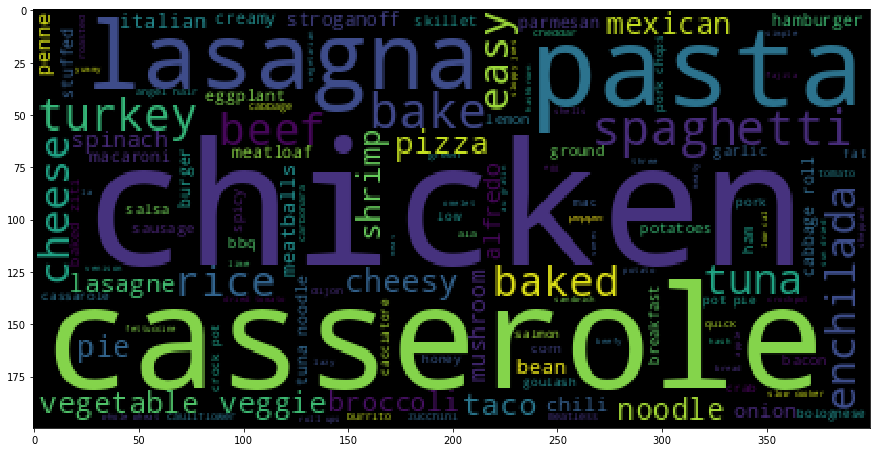

In [63]:
plt.figure(figsize=(15, 15))
plt.imshow(high_cal_wc, interpolation="nearest")

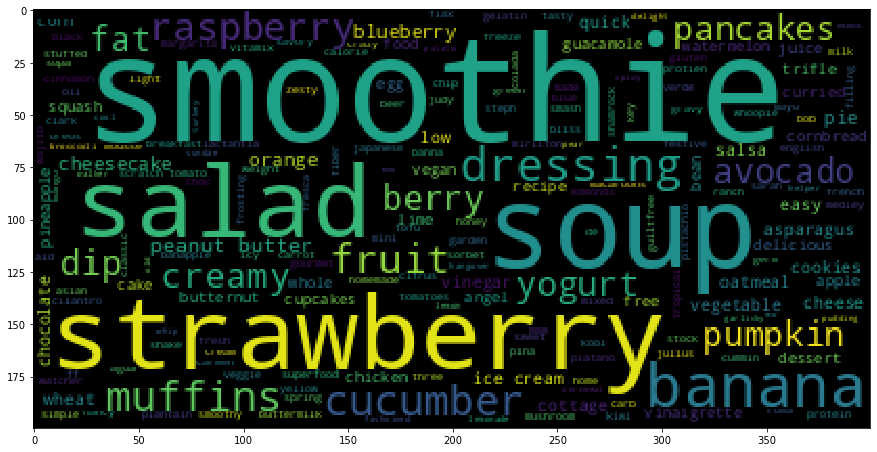

In [64]:
plt.figure(figsize=(15, 15))
plt.imshow(low_cal_wc, interpolation="nearest")

# Persist Model

In [68]:
!ls ../../models

calorie_regression_mobilenet.pt


In [69]:
torch.save(model_ft, "../../models/calorie_regression_mobilenet_.pt")

/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CalorieNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvBNReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mike/.conda/envs/seefood/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon l